# Расхождение Кульбака-Лейблера. Перекрёстная энтропия.
Очень распространенной задачей машинного обучения является задача *классификации*.

Допустим, у вас есть фотографии кошек и собак.
Вы хотите посмотреть на фотографию и предсказать, будет это изображение кошки или собаки.

На вход модели вы подали изображение собаки.

Пусть на выходе вы получили: “есть 80% вероятность, что это изображение собаки, и 20% вероятность - кошки."

Насколько хорошо сработала ваша модель, сказав, что это собака на 80%?
Нам нужно сделать некоторую оценку нашей модели, для её дальнейшей оптимизации, т.е. выбрать функцию ошибки.
Для задачи регрессии(тут есть такой параграф) хорошая функция ошибки - сумма квадратов отклонений предсказанных ответов от правильных *(MSE)*. Но это для задач регрессии. Как выбрать функцию ошибки для задачи классификации?
Нам нужно отделить фотографии кошек от фотографий собак. Давайте просто посчитаем, сколько раз мы верно определили класс, а сколько ошиблись. Тогда функцией ошибки будет доля верных ответов из предсказанных.
Такая материка называется *точностью* или *accuracy*.
Круто, но не очень, потому что функция, которая просто посчитывает число верных ответов, является кусочно-постоянной(( Она всегда локально постоянна, и маленькие изменения в классификаторе практически никогда не приведут к изменению ответа на каких-то тестовых примерах. Есть только некий конечный набор разделяющих поверхностей, на которых значение функции внезапно и резко меняется. 


тут должно быть что-то с примером про прямые


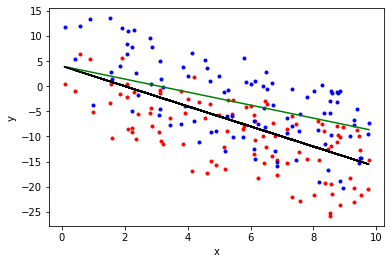

In [2]:
from matplotlib import pyplot as plt
import numpy as np

all_accuracy = {}
def accuracy(a, b, X, y_red, y_blue):
    count_good_red = count_good_blue = 0
    for now_point in range(len(X)):
        y_new = a * X[now_point] + b
        
        if y_red[now_point] < y_new:
            count_good_red += 1
        if y_blue[now_point] > y_new:
            count_good_blue += 1
    accuracy = (count_good_red + count_good_blue) / 200
    all_accuracy[finder] =  accuracy
    return accuracy

def get_two_points(a, x_max, x_min, b=4):
    X = np.array([x_min, x_max])
    Y = np.array([a*x + b for x in X])
    return X, Y

count_point = 100
a = -2
b = 4

far = 20
draining = far / 3

X = 10 * np.random.rand(count_point, 1)
y_red = a*X + b - np.random.rand(count_point, 1)*far + draining
y_blue = a*X + b + np.random.rand(count_point, 1)*far - draining 
y_original = a * X + b

step = 0.001
finder = a - 5
max_accuracy = accuracy(a=finder, b=b, X=X, y_red=y_red, y_blue=y_blue)
while finder <= a + 5:
    now_accuracy = accuracy(a=finder, b=b, X=X, y_red=y_red, y_blue=y_blue)
    if now_accuracy > max_accuracy:
        max_accuracy = now_accuracy
    finder += step

best_item = sorted(all_accuracy.items(), key=lambda x: x[1], reverse=True)[0] #лучший
x, y = get_two_points(a=best_item[0], x_max=max(X), x_min=min(X))


plt.plot(X, y_red, '.', color = 'red')
plt.plot(X, y_blue, '.', color = 'blue')
plt.plot(x, y, linestyle='-', color='green') #best прямая
plt.plot(X, y_original, linestyle='-', color='black') #start прямая

plt.xlabel('x')
plt.ylabel('y')
plt.show()


Построим функцию точности

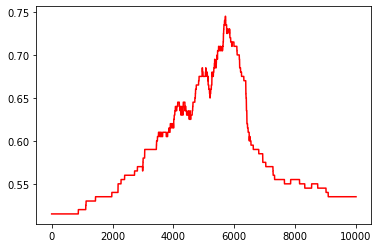

In [3]:
values = list(all_accuracy.values())
y = list(range(1, len(all_accuracy) + 1))
plt.plot(np.array(y), np.array(values), linestyle='-', color='red')
plt.show()

Чуть-чуть расстянем график

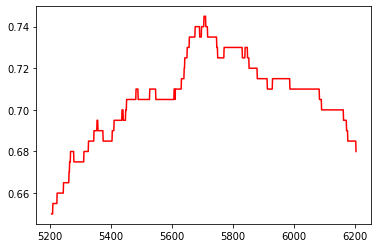

In [4]:
max_value_index = values.index(max(values))
rangerr = 500
y = list(range(1, len(all_accuracy) + 1))
plt.plot(y[max_value_index-rangerr:max_value_index+rangerr], values[max_value_index-rangerr:max_value_index+rangerr], linestyle='-', color='red')
plt.show()


Непонятно, как такую функцию оптимизировать. Метод градиентного спуска в этом случае бесполезен, потому что производная в каждой точке такой функции либо равна нулю, либо вообще не существует.

Как же тогда оценить, насколько хорошо работает наша модель,
и сделать это с помощью гладкой функции, которую можно будет потом оптимизировать?

*С помощью перекрёстной энтропии и дивергенции Кульбака-Лейблера.*


Прежде чем говорить о перекрёстной энтропии, нужно вспомнить, что такое энтропия, а для этого нам нужно знать, что такое распределение. 

### Немного из теории вероятностей.


***Распределение вероятностей*** — это закон, описывающий область значений случайной величины и соответствующие вероятности появления этих значений.


Это всё конечно здорово, но станет гораздо понятнее, если попытаться визуализировать какое-то простое вероятностное распределение.

Например: 
Лето в Москве было солнечное, но иногда шел дождь.
Скажем, что в Москве солнечно в 75% случаев.

![image.png](https://hsto.org/r/w1560/webt/a4/5z/ws/a45zwsas5qbn-jhwwcopgzs66cu.png)

Большинство дней я ношу футболку, но иногда я надеваю плащ.

 Допустим, я ношу плащ 38% времени.

![image.png](https://hsto.org/r/w1560/webt/sn/nw/cr/snnwcrcmmlwcj9eurf7ht6obbqy.png)


Более вероятно, что я ношу плащ в день, когда идет дождь, чем то, что я ношу плащ в один день, а дождь идет в другой случайный день.

В таком случае можно рассмотреть *условные вероятности* - вероятность наступления одного события, при условии, что произошло другое. 

Какова вероятность того, что я надену футболку, если солнечно? Какова вероятность того, что я надену плащ, если идет дождь?

![image.png](https://hsto.org/r/w1560/webt/k-/-3/3n/k--33n4n-qzhr8tzcqtof93rbcm.png)


С вероятностью 25% идет дождь. Если идет дождь, с вероятностью 75% я надену плащ. 

Таким образом, условная вероятность того, я ношу плащ, если идёт дождь, равна 25% от 75%, что составляет приблизительно 19%.

*Совместная вероятность* того, что идет дождь, и я ношу плащ, — это вероятность того, что идет дождь, умноженная на вероятность того, что я ношу плащ, если идет дождь. 

Это можно записать так:

#### $p(rain, coat)=p(rain)p(coat|rain)$

Это пример одного из фундаментальных тождеств теории вероятностей:
#### $p(x, y)=p(x)p(y|x)$

Мы факторизуем распределение, разбивая его на произведение двух частей. Сначала мы смотрим вероятность того, что одна переменная — погода, примет определенное значение. Затем мы смотрим на вероятность того, что другая переменная — моя одежда, примет значение, обусловленное первой переменной.

С какой переменной начинать не имеет значения. Мы могли бы начать с моей одежды, а затем посмотреть на погоду, обусловленную этим. Это может показаться менее интуитивным, потому что мы понимаем, что погода влияет на то, как я одет, а не наоборот… но это все равно работает!


### Энтропия из теории информации - Энтропия по Шеннону. Расстояние Кульбака-Лейблера и перекрёстная энтропия.
*Величина H играет центральную роль в теории информации в качестве меры количества информации, возможности выбора и неопределенности.*
*(Клод Шеннон)*

Пусть наше пространство событий состоит из n разных событий.

Тогда энтропия по Шеннону равна:
#### $H = -\displaystyle\sum_{i=1}^{n} p_i\times{log p_i}$, *где n - число событий, $p_i$ - вероятности всех событий*

Пусть есть распределение p(x), тогда энтропия для этого распределения:


#### $H(p) = -\displaystyle\sum_{x} p(x)\times{log p(x)}$

Пусть есть ещё распределение q(x), тогда энтропия для этого распределения:

#### $H(q) = -\displaystyle\sum_{x} q(x)\times{log q(x)}$

Тогда перекрёстная энтропия - насколько распределение p отличается от распределения q.

#### $H_q(p) = -\displaystyle\sum_{x} p(x)\times{logq(x)}$

Чем сильнее отличаются распределения $p$ и $q$, тем больше перекрестная энтропия $p$ относительно $q$ будет больше энтропии $p$.

Из теории информации в информатику пришло понятие *относительной энтропии* или *расстояния Кульбака-Лейблера (KL-дивергенция)* - разница между энтропией и перекрестной энтропией.

KL-дивергенция $D_q(p)$ для распределения $p$ относительно распределения $q$ определяется так:

#### $D_q(p) = H_q(p) - H(p) = \int{p(x)log\frac{p(x)}{q(x)}dx}$

Самое замечательное в KL-дивергенции то, что она похожа на расстояние между двумя распределениями - измеряет, насколько они разные!
![image.png](https://hsto.org/r/w1560/webt/yh/dh/g6/yhdhg6eapdchnfyhjgdt515spaw.png)

### Как использовать дивергенцию Кульбака-Лейблера для решения задачи классификации(про кошек и собак на фото)?
Мы решили принять за функцию ошибки долю правильных ответов нашей модели, т.е. насколько распределение на тестовых примерах, созданное классификатором *q*, похоже или непохоже на истинное распределение, задаваемое данными *p*.

Давайте начнём с бинарной классификации, где входные данные имеют вид (x, y) и y принимает только два значения - 0 и 1.

Введем распределение данных:
$p(y=1)=y$ , a $p(y=0)=1-y$.
Это значит, что в распределении данных все значения будут равны 0 или 1, а распределение классификатора будет какое получится. Классификатор пытается оценить вероятность положительного ответа $p(y | D,x)$ *(D - набор данных)* и именно её мы будем считать вероятностью $q(y)$.

Минимизировать будем не KL-дивергенцию, а перекрёстную энтропию(выше я писала, как они связаны между собой):

$H(p, q) = -\displaystyle\sum_{y} p(y)\times{log_q(y)}$
Для бинарной классификации целевая функция, которую мы будем минимизировать на наборе данных $D = {(x_i, y_i)}^N_{i=1}$, обычно выглядит как средняя перекрёстная энтропия по всем точкам данных:

$L(\theta) = H(p_d, q(\theta)) = -\frac{1}{N}\displaystyle\sum_{i=1}^{N}(y_ilogy'_i(\theta)+(1 - y_i)log(1 - y'_i(\theta)))$, где $y'_i(\theta)$ - оценка вероятности ответа 1, полученная классификатором.

В результате мы получаем непрерывную функцию $L(\theta)$ от предсказанных классификатором вероятностей, которая оценивает, насколько хорошо он предсказывает метки в данных. $L(\theta)$ может служить функцией ошибки; ее можно дифференцировать, и вся оптимизация работает прекрасно, что мы и хотели получить. 

Понимать, как математически устроено представление задач классификации, крайне важно: большинство практических задач — это именно задачи классификации, и целевая функция в таком виде, как показано выше, будет постоянно встречаться в вашей практике анализа данных.


*Неужели я дописала эту штуку.....*


>  матриченое диф.: http://www.machinelearning.ru/wiki/images/5/50/MOMO17_Seminar2.pdf

Найдем градиент перекрестной энтропии для произвольной точки (экземпляра датасета): $L(\theta) = -y \log\big(\tilde{y}(\theta)\big) -\big(1-y\big) \log\big(1-\tilde{y}(\theta)\big)$. В случае логистической регрессии: $\tilde{y} = \sigma(\theta^{T}x)$. Также заметим, что $\sigma'(x)=\sigma(x)\big(1-\sigma(x)\big)$.

$$
\begin{align}
dL(\theta) &= -y d\bigg[\log\big(\sigma(\theta^{T}x)\big)\bigg] -\big(1-y\big) d\bigg[ \log\big(1-\sigma(\theta^{T}x)\big)\bigg] = \\
&= -y \frac{d\big[\sigma(\theta^{T}x)\big]}{\sigma(\theta^{T}x)} -\big(1-y\big) \frac{d\big[1 - \sigma(\theta^{T}x)\big]}{1 - \sigma(\theta^{T}x)} = \\
&= -y \frac{\sigma(\theta^{T}x)\big(1-\sigma(\theta^{T}x)\big)d\big[\theta^{T}x\big]}{\sigma(\theta^{T}x)}
- \big(1-y\big)\frac{-\sigma(\theta^{T}x)\big(1-\sigma(\theta^{T}x)\big)d\big[\theta^{T}x\big]}{1 - \sigma(\theta^{T}x)} = \\
&= -y \big(1-\sigma(\theta^{T}x)\big)x + (1-y)\sigma(\theta^{T}x)x = \\
&= \bigg((1-y)\sigma(\theta^{T}x) - y \big(1-\sigma(\theta^{T}x)\big)\bigg)x = \\
&= \big( \sigma(\theta^{T}x) - y\sigma(\theta^{T}x) - y + y\sigma(\theta^{T}x) \big)x = \\
&= \bbox[5px, border: 2px solid red]{\big( \sigma(\theta^{T}x) - y \big)x}
\end{align}
$$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


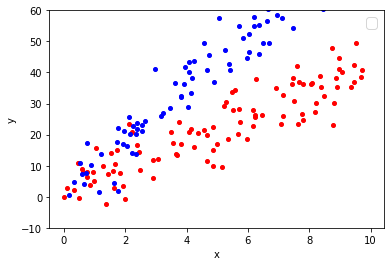

In [89]:
real_a = 4
real_b = 2

X1 = 10*np.random.rand(100,1)
Y1 = real_a*X1 + real_b + np.random.randn(100,1)*6

X2 = 10*np.random.rand(100,1)
Y2 = 2*real_a*X2 + real_b + 1 + np.random.randn(100,1)*6

dX = np.linspace(0,10,100)
#Y_gt = real_a*dX + real_b

#plt.plot(dX, Y_gt, 'g-', linewidth=3, label='y(x)=4x+2')
plt.plot(X1, Y1, 'r.', markersize=8)
plt.plot(X2, Y2, 'b.', markersize=8)
plt.ylim(-10,60)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 14})
plt.show()

In [90]:
C1 = np.concatenate([X1, Y1, np.zeros_like(Y1)], -1)
C2 = np.concatenate([X2, Y2, np.ones_like(Y2)], -1)
D = np.concatenate([C1, C2], 0)
X = np.concatenate([D[:,:2], np.ones_like(D[:,2:])], -1)
Y = D[:,2:]

In [91]:
X.shape

(200, 3)

In [142]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sgd_2d_logistic_regresion(X, y, n_epochs = 5, eta = 0.01):
    m = X.shape[0]
    theta_path = []
    theta = np.random.randn(3,1)*5
    grads_hist = []

    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(m)
        for i in range(m):
            #random_index = np.random.randint(m)
            xi = X[shuffled_indices[i]: shuffled_indices[i]+1]
            yi = y[shuffled_indices[i]: shuffled_indices[i]+1]
            grads = xi.T.dot(sigmoid(xi.dot(theta)) - yi)
            theta = theta - eta * grads

        theta_path.append(theta)
        grads_hist.append(grads)
  
    return theta, np.array(theta_path), grads_hist

In [197]:
theta, theta_path, grads_hist = sgd_2d_logistic_regresion(X, Y, 1000, eta=0.001)

In [198]:
theta

array([[-1.98809746],
       [ 0.33575287],
       [-1.25683356]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


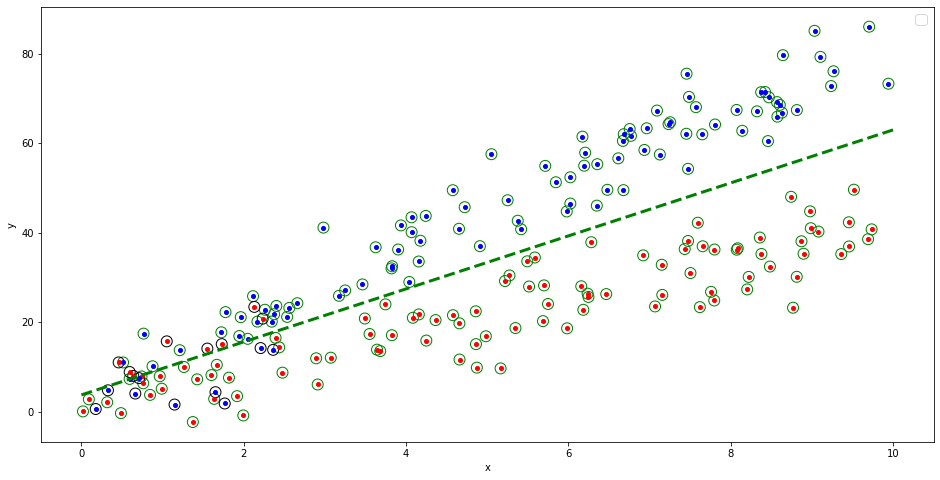

In [199]:
l = -theta[0]/theta[1]*dX - theta[2]/theta[1]

pred = sigmoid(np.matmul(X,theta)) > 0.5

correct = pred[:,0]==D[:,2]
wrong = ~correct
fig = plt.figure(figsize=(16,8))
plt.plot(X1, Y1, 'r.', markersize=8)
plt.plot(X2, Y2, 'b.', markersize=8)
plt.plot(dX, l, 'g--', linewidth=3)
plt.scatter(D[:,0][correct], D[:,1][correct], s=120, facecolors='none', edgecolors='g')
plt.scatter(D[:,0][wrong], D[:,1][wrong], s=120, facecolors='none', edgecolors='black')
#plt.ylim(-10,60)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 14})
plt.show()

In [200]:
print('Точность = ', np.mean(correct))

Точность =  0.915


In [201]:
grads_hist = np.array(grads_hist)

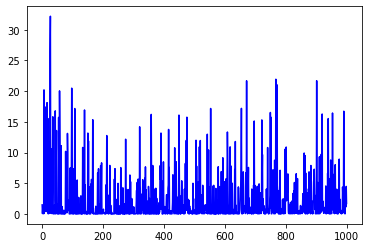

In [202]:
plt.plot(np.linalg.norm(grads_hist[:,:,0], axis=1), 'b')
plt.show()

[]

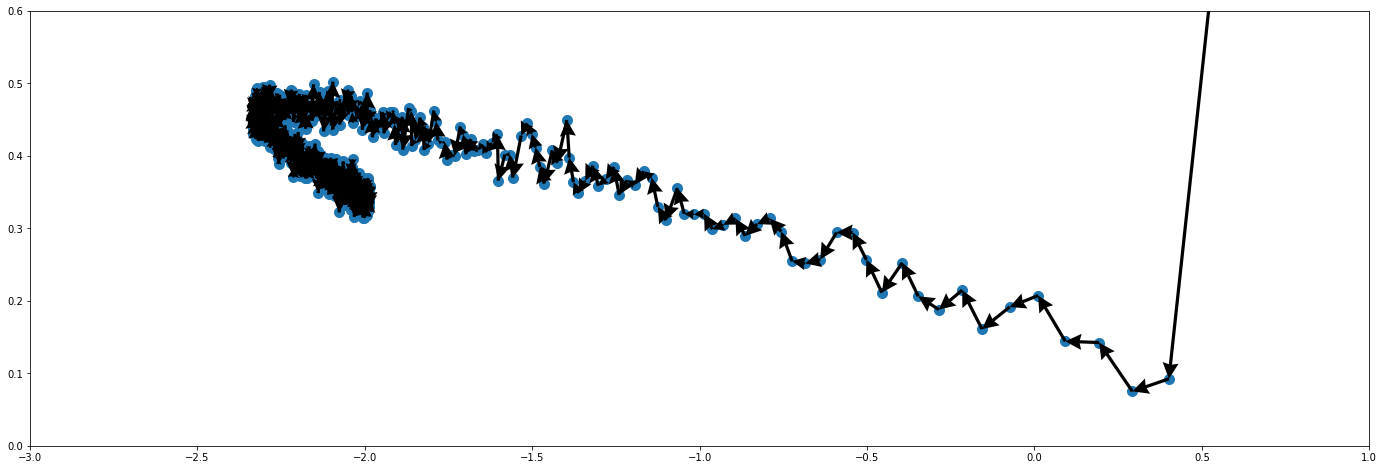

In [242]:
fig = plt.figure(figsize=(24,8))
plt.scatter(theta_path[:,0,0], theta_path[:,1,0], s=100)
plt.quiver(
    theta_path[:-1,0,0], 
    theta_path[:-1,1,0], 
    theta_path[1:,0,0]-theta_path[:-1,0,0], 
    theta_path[1:,1,0]-theta_path[:-1,1,0],
    angles='xy', scale_units='xy', scale=1, headwidth=5
)
plt.xlim(-3,1)
plt.ylim(0.0,0.6)
plt.plot()

[]

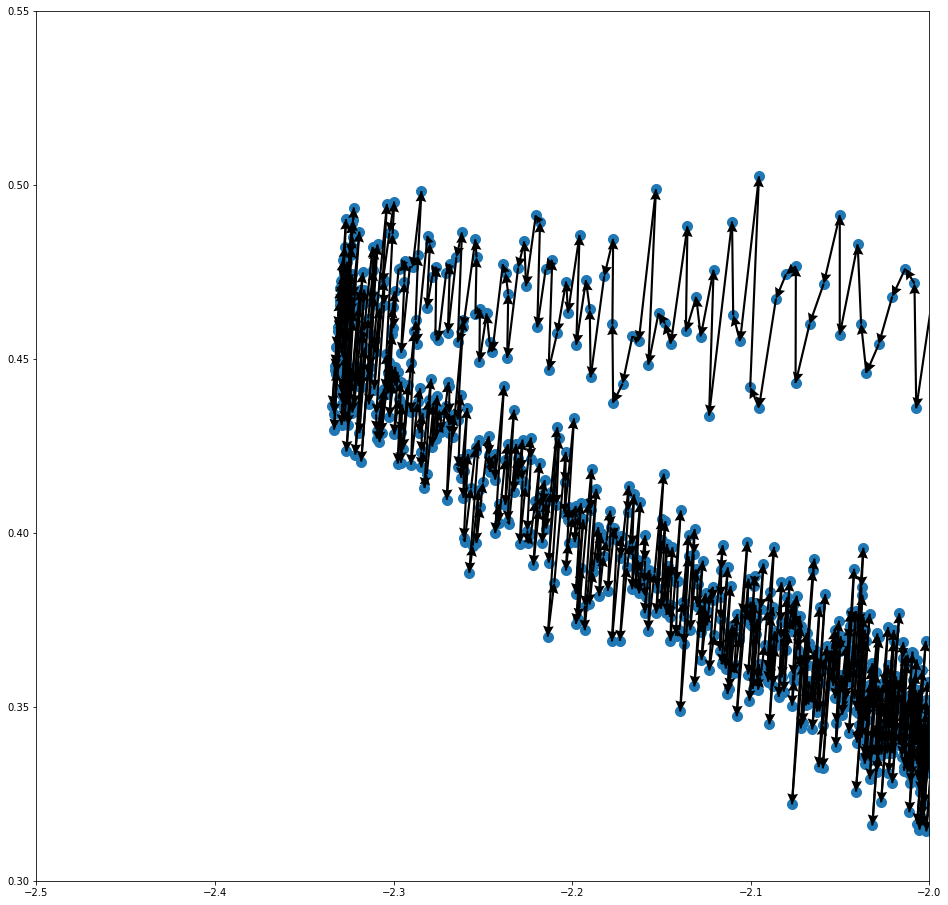

In [247]:
fig = plt.figure(figsize=(16,16))
plt.scatter(theta_path[:,0,0], theta_path[:,1,0], s=100)
plt.quiver(
    theta_path[:-1,0,0], 
    theta_path[:-1,1,0], 
    theta_path[1:,0,0]-theta_path[:-1,0,0], 
    theta_path[1:,1,0]-theta_path[:-1,1,0],
    angles='xy', scale_units='xy', scale=1, headwidth=5
)
plt.xlim(-2.5,-2)
plt.ylim(0.3,0.55)
plt.plot()

## Многоклассовая классификация

## Классификация с порядком